In [103]:
import itertools
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

In [104]:
"""Overall initialization"""

seed = 41
torch.manual_seed(seed)

# Data types
dtype = torch.FloatTensor
np_dtype = np.float32

# PI and Gaussian PDF constants in Torch
pi_tensor = torch.Tensor([np.pi])
pi_variable = Variable(pi_tensor)
normal_log_likelihood_const = -torch.log(torch.sqrt(2 * pi_variable))

# Use cross entropy or L2-norm for reconstruction loss?
use_cross_entropy = True

# Model parameters
latent_size = 20

# Training parameters
batch_size = 128
learning_rate = 1e-3

# Data parameters
mnist_dataset_path = 'mnist_dataset'

# Hidden layer units in encoder and decoder (each entry is one layer)
enc_hidden_units_list = [512, 512]
dec_hidden_units_list = [512, 512]

In [105]:
"""Datasets"""

# Only return full batches
kwargs = {"drop_last": True}
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(mnist_dataset_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(mnist_dataset_path, train=False,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

# Retrieve size of images
image, label = train_loader.dataset[0]
image_size_x, image_size_y = image.size()[-2:]
image_size_flat = image_size_x * image_size_y

# Retrieve number of labels
max_label = 0
for images, labels in train_loader:
    max_label = max(max_label, np.max(labels.numpy()))
num_labels = int(max_label + 1)

In [106]:
"""Network model for encoder and decoder"""

class VAE(nn.Module):

    def __init__(self, input_size, cond_size, latent_size, enc_hidden_units_list, dec_hidden_units_list):
        super(VAE, self).__init__()

        self.input_size = input_size
        self.cond_size = cond_size
        self.latent_size = latent_size

        # Encoder layers
        self.enc_fc_list = nn.ModuleList()
        prev_layer_size = input_size + cond_size
        for i, num_hidden_units in enumerate(enc_hidden_units_list):
            fc = nn.Linear(prev_layer_size, num_hidden_units)
            self.enc_fc_list.append(fc)
            prev_layer_size = num_hidden_units
        self.enc_mu = nn.Linear(prev_layer_size, latent_size)
        self.enc_logvar = nn.Linear(prev_layer_size, latent_size)

        # Decoder layers
        self.dec_fc_list = nn.ModuleList()
        prev_layer_size = latent_size + cond_size
        for i, num_hidden_units in enumerate(dec_hidden_units_list):
            fc = nn.Linear(prev_layer_size, num_hidden_units)
            self.dec_fc_list.append(fc)
            prev_layer_size = num_hidden_units
        self.dec_reconstruct = nn.Linear(prev_layer_size, input_size)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, cond):
        h = torch.cat([x, cond], dim=-1)
        for fc in self.enc_fc_list:
            h = fc(h)
            h = self.relu(h)
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar

    def decode(self, z, cond):
        h = torch.cat([z, cond], dim=-1)
        for fc in self.dec_fc_list:
            h = fc(h)
            h = self.relu(h)
        x_reconstruct = self.dec_reconstruct(h)
        x_reconstruct = self.sigmoid(x_reconstruct)
        return x_reconstruct

    def sample_latent_space(self, num_samples, dtype=torch.FloatTensor, volatile=False):
        z = Variable(torch.randn(num_samples, self.latent_size).type(dtype), volatile=volatile)
        return z

    def sample_latent_space_parametrized(self, mu, logvar):
        if self.training:
          sigma = logvar.mul(0.5).exp_()
          eps = Variable(sigma.data.new(sigma.size()).normal_())
          return eps.mul(sigma).add(mu)
        else:
          return mu

    def forward(self, x, cond):
        mu, logvar = self.encode(x.view(-1, self.input_size), cond)
        z = self.sample_latent_space_parametrized(mu, logvar)
        x_reconstruct = self.decode(z, cond)
        return x_reconstruct, mu, logvar

model = VAE(image_size_flat, num_labels, latent_size, enc_hidden_units_list, dec_hidden_units_list)

In [109]:
"""KL divergence between gaussian with diagonal covariance and zero-mean, unit-variance gaussian"""

def kl_divergence_normal_uncorrelated_identity_logvar(mu1, logvar1):
    kld = 0.5 * torch.sum(mu1.pow(2) + logvar1.exp() - 1 - logvar1, dim=-1)
    return kld

In [113]:
"""Training"""

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(true_x, x, mu, logvar, return_loss_components=False):
    # Compute data loss
    if use_cross_entropy:
        bce = nn.functional.binary_cross_entropy(x, true_x.view(-1, image_size_flat))
        recon_loss = bce
    else:
        recon_loss = torch.mean((true_x.view(-1) - x.view(-1)).pow(2))
    # Compute KL-divergence between `N(latent_mu, latent_sigma)` and unit normal distribution
    kld_q = kl_divergence_normal_uncorrelated_identity_logvar(mu, logvar)
    kld_q = torch.mean(kld_q) / (image_size_flat)
    # Total loss
    loss = recon_loss + kld_q
    if return_loss_components:
        return loss, recon_loss, kld_q
    else:
        return loss

model.training = True

num_epochs = 10
cond = Variable(torch.FloatTensor(batch_size, num_labels))
for epoch in range(num_epochs):
    train_loss = 0
    train_recon_loss = 0
    train_kld = 0
    for i, (images, labels) in enumerate(train_loader):
        x = Variable(images)
        cond.data.zero_()
        cond.scatter_(1, labels.view(batch_size, 1), 1)

        optimizer.zero_grad()
        reconstruct_x, mu, logvar = model(x, cond)
        loss, recon_loss, kld = loss_function(x, reconstruct_x, mu, logvar, return_loss_components=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        train_recon_loss += recon_loss.data[0]
        train_kld += kld.data[0]
        if i % 100 == 0:
            print("epoch={}, i={}".format(epoch, i))
            print("  loss: {:.4f}, recon_loss: {:.4f}, kld: {:.4f}".format(
                train_loss / (i + 1), train_recon_loss / (i + 1), train_kld / (i + 1)))
    train_loss *= batch_size / len(train_loader.dataset)
    train_recon_loss *= batch_size / len(train_loader.dataset)
    train_kld *= batch_size / len(train_loader.dataset)
    print('====> Train set loss: {:.4f}, recon_loss: {:.4f}, kld: {:.4f}'.format(
        train_loss, train_recon_loss, train_kld))

epoch=0, i=0
  loss: 0.1321, recon_loss: 0.1112, kld: 0.0208
epoch=0, i=100
  loss: 0.1328, recon_loss: 0.1121, kld: 0.0207
epoch=0, i=200
  loss: 0.1324, recon_loss: 0.1116, kld: 0.0208
epoch=0, i=300
  loss: 0.1319, recon_loss: 0.1111, kld: 0.0208
epoch=0, i=400
  loss: 0.1315, recon_loss: 0.1107, kld: 0.0208
====> Train set loss: 0.1312, recon_loss: 0.1104, kld: 0.0208
epoch=1, i=0
  loss: 0.1236, recon_loss: 0.1032, kld: 0.0204
epoch=1, i=100
  loss: 0.1296, recon_loss: 0.1086, kld: 0.0210
epoch=1, i=200
  loss: 0.1297, recon_loss: 0.1086, kld: 0.0211
epoch=1, i=300
  loss: 0.1294, recon_loss: 0.1083, kld: 0.0211
epoch=1, i=400
  loss: 0.1292, recon_loss: 0.1081, kld: 0.0211
====> Train set loss: 0.1290, recon_loss: 0.1079, kld: 0.0211
epoch=2, i=0
  loss: 0.1340, recon_loss: 0.1125, kld: 0.0216
epoch=2, i=100
  loss: 0.1279, recon_loss: 0.1067, kld: 0.0213
epoch=2, i=200
  loss: 0.1279, recon_loss: 0.1066, kld: 0.0213
epoch=2, i=300
  loss: 0.1278, recon_loss: 0.1066, kld: 0.0213


KeyboardInterrupt: 

torch.Size([8, 1, 28, 28])


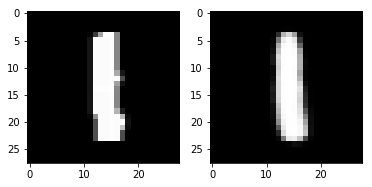

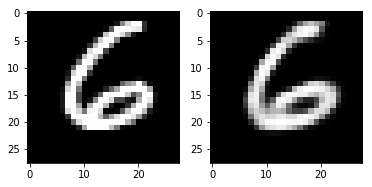

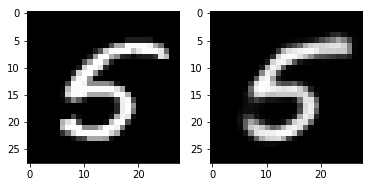

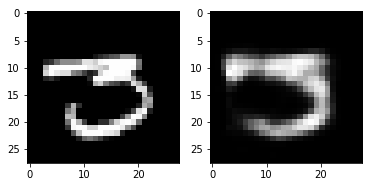

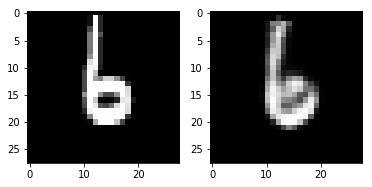

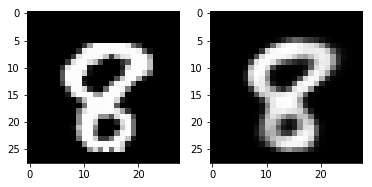

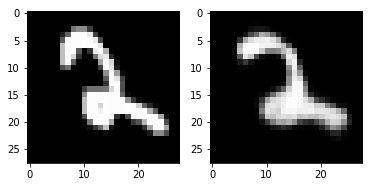

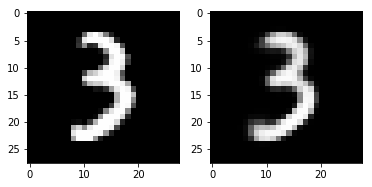

====> Test set loss: 0.0009


In [116]:
"""Compare input and reconstructed images"""

model.eval()
test_loss = 0
cond = Variable(torch.FloatTensor(batch_size, num_labels))
for i, (images, labels) in enumerate(test_loader):
    x = Variable(images, volatile=True)
    cond.data.zero_()
    cond.scatter_(1, labels.view(batch_size, 1), 1)

    recon_x, mu, logvar = model(x, cond)
    test_loss += loss_function(x, recon_x, mu, logvar).data[0]
    if i == 0:
        n = min(x.size(0), 8)
        print(x[:n].size())
        comparison = torch.cat([x[:n],
                                recon_x.view(batch_size, 1, image_size_x, image_size_y)[:n]])
        for j in range(n):
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(comparison[j, 0, ...].data.numpy(), cmap="gray")
            plt.subplot(1, 2, 2)
            plt.imshow(comparison[n + j, 0, ...].data.numpy(), cmap="gray")
            plt.show()

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

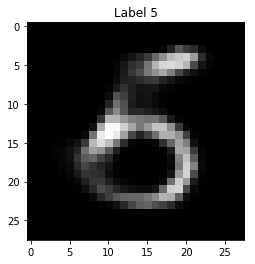

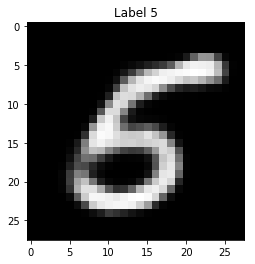

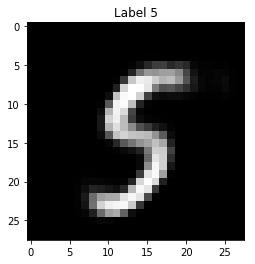

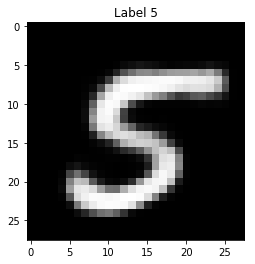

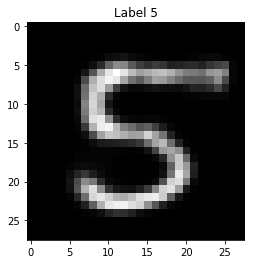

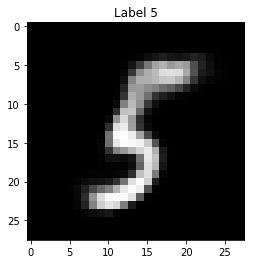

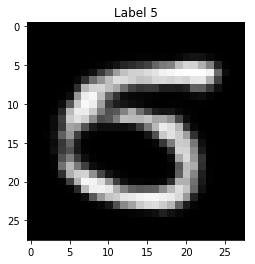

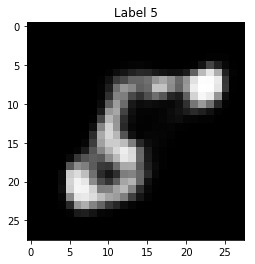

In [115]:
"""Sample some images from latent space"""

model.eval()
num_samples_to_generate = 8
samples = Variable(torch.randn(num_samples_to_generate, latent_vec_size))
labels = Variable(5 * torch.ones(num_samples_to_generate)).type(torch.LongTensor)
# labels = Variable(torch.from_numpy(np.random.randint(num_labels, size=num_samples_to_generate)).type(torch.LongTensor))
cond = Variable(torch.FloatTensor(num_samples_to_generate, num_labels))
cond.data.zero_()
cond.scatter_(1, labels.view(num_samples_to_generate, 1), 1)
assert labels.max()[0].data.numpy() < num_labels
samples = model.decode(samples, cond)
for i in range(num_samples_to_generate):
    sample = samples[i, ...]
    sample = sample.view(image_size_y, image_size_x)
    sample = sample.data.numpy()
    plt.figure()
    plt.imshow(sample, cmap="gray")
    plt.title("Label {}".format(labels.data[i]))
    plt.show()